<a href="https://colab.research.google.com/github/abakamousa/demo_kmerai/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install librairies

In [1]:
!pip install opendatasets
#!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import librairies

In [2]:
import numpy             as np 
import pandas            as pd 
import opendatasets      as od
import seaborn           as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing     import LabelEncoder
from sklearn.ensemble          import RandomForestClassifier
from sklearn.linear_model      import SGDClassifier
from sklearn.linear_model      import LogisticRegression
from xgboost                   import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing     import RobustScaler
from imblearn.over_sampling    import SMOTE 
from sklearn.model_selection   import train_test_split, GridSearchCV
from collections               import Counter
from sklearn.pipeline          import Pipeline
#from dython.nominal        import associations #for correlation analysis between categorical and continuous values

# Load dataset from kaggle

In [3]:
url="https://www.kaggle.com/datasets/ealaxi/paysim1"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abakamousa
Your Kaggle Key: ··········


100%|██████████| 178M/178M [00:01<00:00, 139MB/s]


# Functions

In [4]:
def encode_df (df):
    colName = []
    for i in df.columns:
        if (df[i].dtypes == 'object'):
            colName.append(i)
    # Encode Categorical Columns
    le = LabelEncoder()
    df[colName] = df[colName].apply(le.fit_transform)
    
    return df

# Exploratory data analysis

In [5]:
df = pd.read_csv("/content/paysim1/PS_20174392719_1491204439457_log.csv")

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0




*  step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

*    type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

*    amount - amount of the transaction in local currency.

*    nameOrig - customer who started the transaction

*    oldbalanceOrg - initial balance before the transaction

*    newbalanceOrig - new balance after the transaction

*    nameDest - customer who is the recipient of the transaction

*    oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

*    newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

*    isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

*    isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [7]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [8]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [10]:
df['isFlaggedFraud'].value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

**Countplot of each type of transactions**

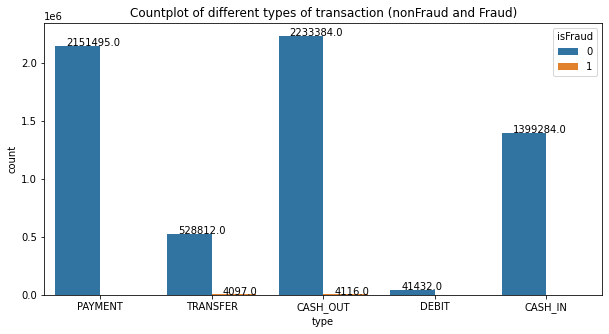

In [11]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x = "type", hue="isFraud", data = df)
plt.title('Countplot of different types of transaction (nonFraud and Fraud)')
for p in ax.patches:
  ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        

**Remarque:** pas de transaction frauduleuse pour les transactions de type PAYMENT, CASH_IN et DEBIT

**Proportion of different transactions**

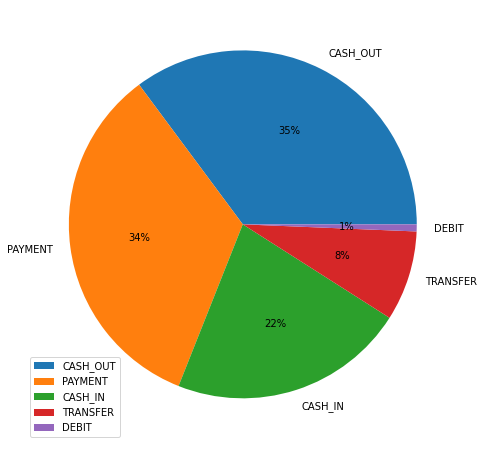

In [12]:
type = df['type'].value_counts()
transaction = type.index
count = type.values

plt.figure(figsize=(8,8))
plt.pie(count, labels=transaction, autopct='%1.0f%%')
plt.legend(loc='lower left')
plt.show()

**Dataset splitting**

Etant donné que l'on peut rencontrer des fraudes sur des opérations de PAYMENT, CASH_IN et DEBIT, nous allons procéder à un découpage de notre jeu de données en deux:

*   Un premier jeu destiné à la réalisation de l'apprentissage non supervisé pour détecter les anomalies en prenant en compte les transactions de type PAYMENT, CASH_IN et DEBIT.
*   Un second jeu destiné à être utilisé pour réaliser un apprentissage supervisé à en prenant en compte les transactions de CASH_OUT et TRANSFER



In [13]:
df_unsupervised = df.loc[(df["type"] == "PAYMENT") | (df["type"] == "CASH_IN") | (df["type"] == "DEBIT")]
df_supervised   = df.loc[(df["type"] == "TRANSFER") | (df["type"] == "CASH_OUT")]

# **Data preparation for supervised ML with df_supervised**

In [14]:
print("Number of duplicated rows: ", df_supervised.duplicated().sum())

Number of duplicated rows:  0


In [15]:
#label encoding
df_supervised = encode_df(df_supervised)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Correlation analysis**

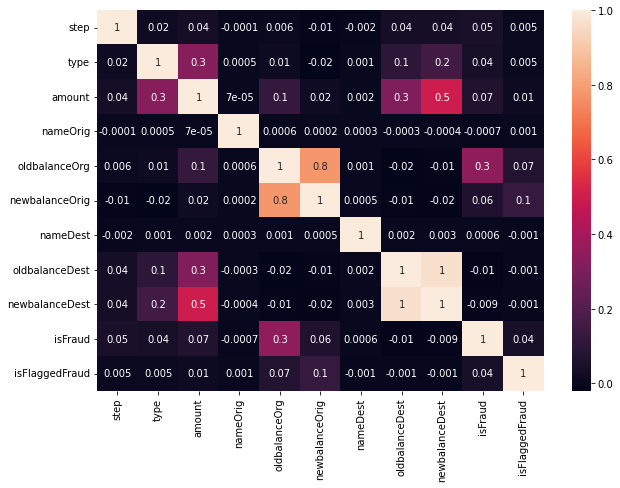

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(df_supervised.corr(), annot = True, fmt='.1g')

**Remarque:** La valeur max de corrélation entre deux variables distinctes de notre dataset est de 0.8.  

**Boxplot**

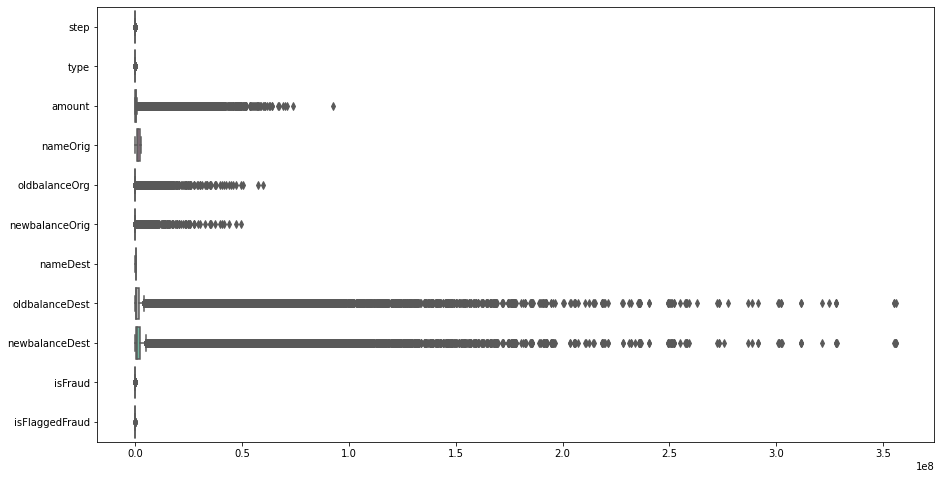

In [17]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_supervised, orient="h", palette="Set2")

Class analysis

In [18]:
df_supervised['isFraud'].value_counts(normalize=True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

Remarque: 
* l'on note que les features ne sont pas à la même échelle
* l'on note la présence d'outlier --> L'on tiendra compte de cela dans le choix de la méthode de normalisation des données

**Feature scaling**

In [19]:
scaler = RobustScaler()
#df_supervised_scaled = scaler.fit_transform(df_supervised)

**Train Test split**

In [20]:
#feature = df_supervised_scaled[:,:-2]
#target  = df_supervised_scaled[:,-2]
feature = df_supervised.drop(['isFraud', 'isFlaggedFraud'], axis=1)
target  = df_supervised.isFraud


In [21]:
#feature selection
new_feature = SelectKBest(f_classif, k=7).fit_transform(feature, target)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(new_feature, target, test_size=0.2)

**Resampling**

In [23]:
sm = SMOTE(sampling_strategy='minority', random_state=237)

X_res, y_res = sm.fit_resample(X_train, y_train)

In [24]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 2209748, 1: 2209748})


# Prediction

In [54]:
#models
clf1 = SGDClassifier()
clf2 = RandomForestClassifier()
clf3 = LogisticRegression()
clf4 = XGBClassifier()


In [55]:
#pipeline

pipe_SGD  = Pipeline([('scaler', scaler), ('SGD', clf1)])
pipe_RF   = Pipeline(steps=[("scaler", scaler), ("RF", clf2)]) 
pipe_LR   = Pipeline(steps=[("scaler", scaler), ("LogisticRegression", clf3)])
pipe_XGB  = Pipeline(steps=[("scaler", scaler), ("XGB", clf4)])

In [56]:
#grid parameters


hyper_params_SGD = [{
'SGD__loss' : ['hinge', 'log', 'squared_hinge', 'modified_huber'],
'SGD__alpha' : np.arange(0, 0.1, 0.01),
'SGD__penalty' : ['l2', 'l1']
}]

hyper_params_RF = [{ 
'RF__n_estimators' : [100, 200, 500, 1000],
'RF__max_features' : ["auto", "sqrt", "log2"],
'RF__bootstrap': [True],
'RF__criterion': ['gini', 'entropy'],
'RF__oob_score': [True, False]
}]


hyper_params_LR = [{
'LogisticRegression__solver': ['newton-cg', 'sag', 'lbfgs'],
'LogisticRegression__multi_class': ['ovr', 'multinomial']
}]

hyper_params_XGB =  [{
'XGB__nthread':[4], #when use hyperthread, xgboost may become slower
'XGB__objective':['binary:logistic'],
'XGB__learning_rate': [0.05], #so called `eta` value
'XGB__max_depth': [6],
'XGB__min_child_weight': [11],
'XGB__silent': [1],
'XGB__subsample': [0.8],
'XGB__colsample_bytree': [0.7],
'XGB__n_estimators': [5], #number of trees, change it to 1000 for better results
'XGB__missing':[-999],
'XGB__seed': [1337]}]




In [57]:
SGD_grid_search = GridSearchCV(estimator=pipe_SGD,
        param_grid=hyper_params_SGD,
        scoring='accuracy',
        n_jobs=-1,
        cv=3)

RF_grid_search = GridSearchCV(estimator=pipe_RF,
        param_grid=hyper_params_RF,
        scoring='accuracy',
        n_jobs=-1,
        cv=3)

LR_grid_search = GridSearchCV(estimator=pipe_LR,
        param_grid=hyper_params_LR,
        scoring='accuracy',
        n_jobs=-1,
        cv=3)

XGB_grid_search = GridSearchCV(estimator=pipe_XGB,
        param_grid=hyper_params_XGB,
        scoring='accuracy',
        n_jobs=-1,
        cv=3)

grids = [SGD_grid_search, RF_grid_search, XGB_grid_search, LR_grid_search]

In [53]:
#for param in XGB_grid_search.get_params().keys():
#    print(param)

In [ ]:
for pipe in grids:
    pipe.fit(X_res, y_res)

# Performance evaluation

# Inference